# Diffusion model from scratch

The objective of this notebook is to go through an implementation of a diffusion model applied on a toy example (spirals). For sake of simplicity, we consider a variance preserving stochastic differential equation with ancestral sampling, which corresponds to the denoising diffusion probabilistic model proposed by Ho et al.

This notebook focuses on:
- variance scheduling and forward sampling
- network architecture (conditioning with time)
- loss function (i.e. simplified score matching)
- reverse sampling
- training

The notebook is adapted from Philippe Esling (IRCAM): https://github.com/acids-ircam/diffusion_models

## Data

In this notebook, we will make use of the swiss roll dataset from scikit learn to create a 2D spiral.

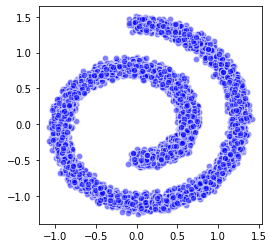

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll

# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(4, 4))
plt.scatter(*data, alpha=0.5, color='blue', edgecolor='white', s=40);

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

dataset = torch.tensor(data.T).float()


## SDE formulation & DDPM

We consider a diffusion process that corrupts data slowly into random noise: 

$$
\mathbf{x}_{t} = \sqrt{1-\beta_{t}}\mathbf{x}_{t-1} + \sqrt{\beta_{t}}\mathbf{z}_{t-1}
$$

with $\mathbf{z}_{t-1} \sim \mathcal{N}(0,I)$ and $\beta_t \in [0,1]$. This corresponds to the following stochastic differential equation:

$$
\mathrm{d}\mathbf{x} = -\frac{1}{2}\beta(t) \mathbf{x} \mathrm{d}t + \sqrt{\beta(t)} \mathrm{d}\mathbf{w}.
$$

It is called the variance preserving SDE. When using ancestral sampling scheme, this SDE-based diffusion approach is equivalent to the denoising diffusion probabilistic model (DDPM) proposed by Ho et al.


## Forward sampling

To sample data in the forward diffusion process, we need to define a number of timesteps ($t \in [0,n\_steps-1]$) and a set of variances $\beta$ using a _scheduler_.

In [10]:
n_steps = 100

In [11]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

Interestingly, the forward process admits sampling $\mathbf{x}_{t}$ at an arbitrary timestep $t$. Using notations $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$, we have

$$
p(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Therefore, we can define a diffusion sampling function using this mecanism. Note that this depends on the given variance schedule of $\beta_{1},\cdots,\beta_{T}$ that we compute prior to the function.

In [12]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

Let define a function to get values of a tensor at specific time to simplify computations.

In [13]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

Let define a forward sample function to visualize the forward diffusion process.

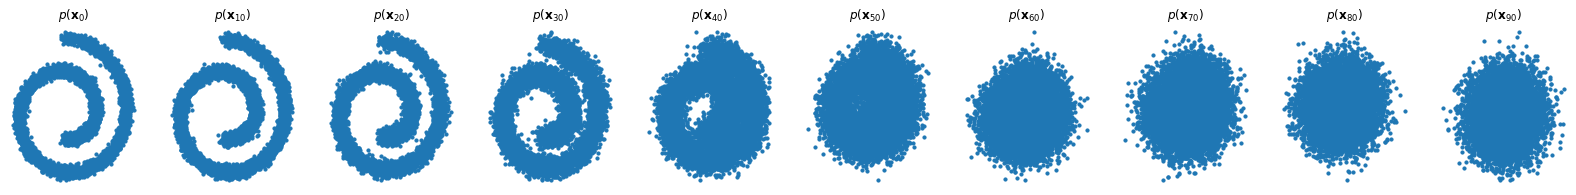

In [14]:
def forward_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = forward_sample(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$p(\mathbf{x}_{'+str(i*10)+'})$')

## Score matching (or denoising) network

We have to define a neural network that estimates the score function, given a sample and a timestep (_conditioning_ on time _t_). The parameters of the neural network are shared across time. To represent time _t_, we use nn.Embedding which is a lookup table that stores embeddings of a fixed dictionary and size. This makes the neural network "know" at which particular time step (noise level) it is operating, for every sample in a batch. In this notebook, the architecture is a MLP conditioned with time.

In [15]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

In [16]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

## Loss function

Let define a function to compute the following loss:
$$
\min_\theta \mathbb{E}_{t,\mathbf{x}_0,\epsilon} \| \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \|^2_2
$$

In [17]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

## Reverse sampling

The overall algorithm of DDPM for reverse sampling is:

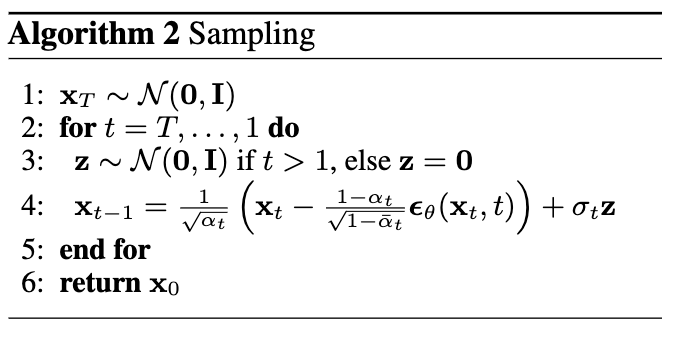

We need to define two functions: one to compute $x_{t-1}$ given $x_t$, and another one to perform the loop. 

In [18]:
def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

## Training (and sampling)

The overall algorithm of DDPM for training is:

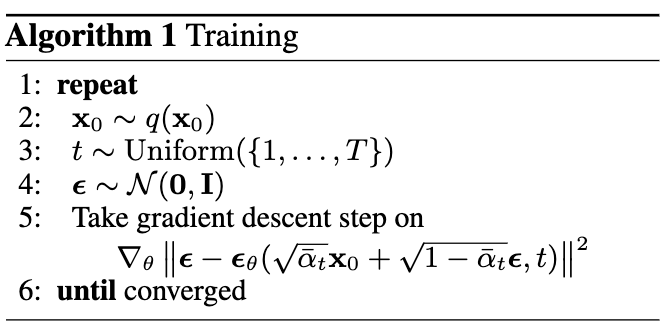

tensor(0.9207, grad_fn=<MeanBackward0>)
tensor(0.6340, grad_fn=<MeanBackward0>)
tensor(1.3081, grad_fn=<MeanBackward0>)
tensor(0.6103, grad_fn=<MeanBackward0>)
tensor(0.6000, grad_fn=<MeanBackward0>)
tensor(0.4300, grad_fn=<MeanBackward0>)
tensor(0.7962, grad_fn=<MeanBackward0>)
tensor(0.7908, grad_fn=<MeanBackward0>)
tensor(0.3156, grad_fn=<MeanBackward0>)
tensor(0.5351, grad_fn=<MeanBackward0>)


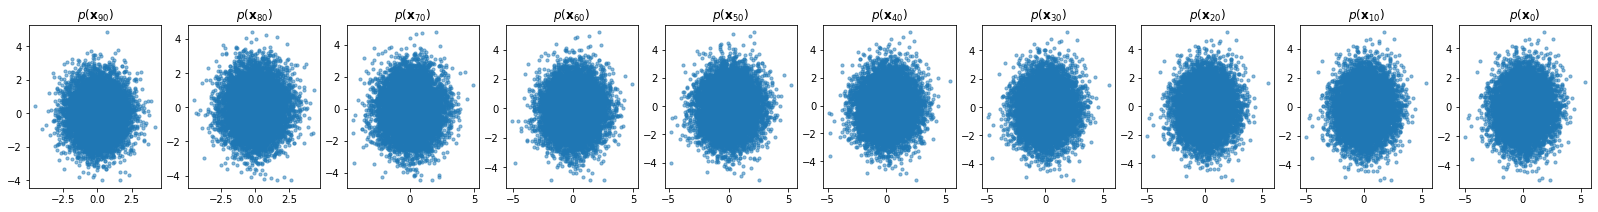

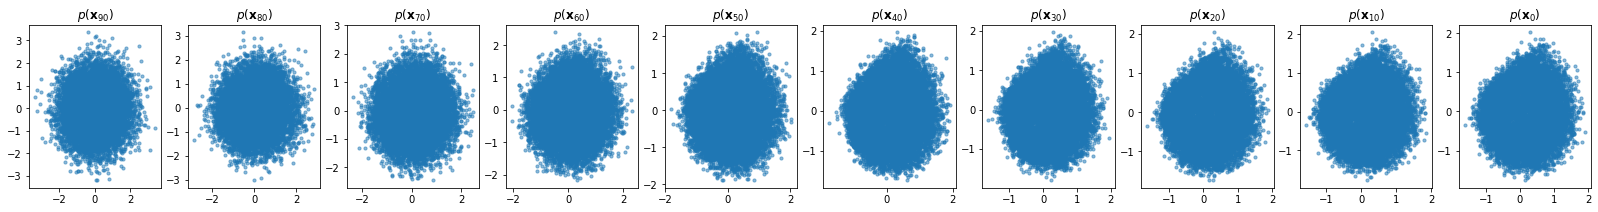

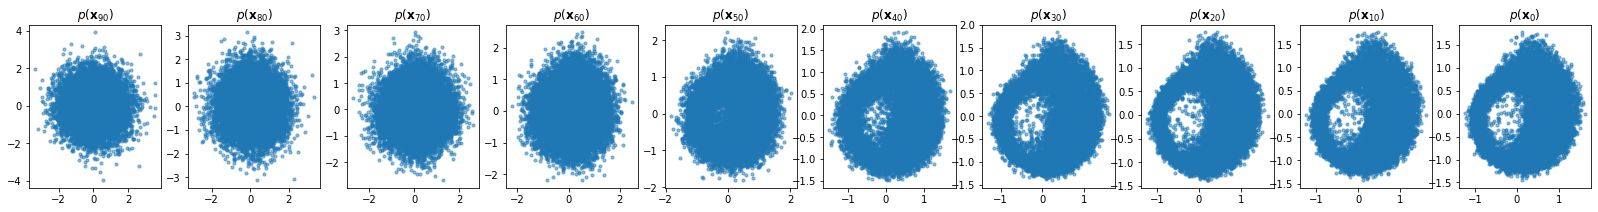

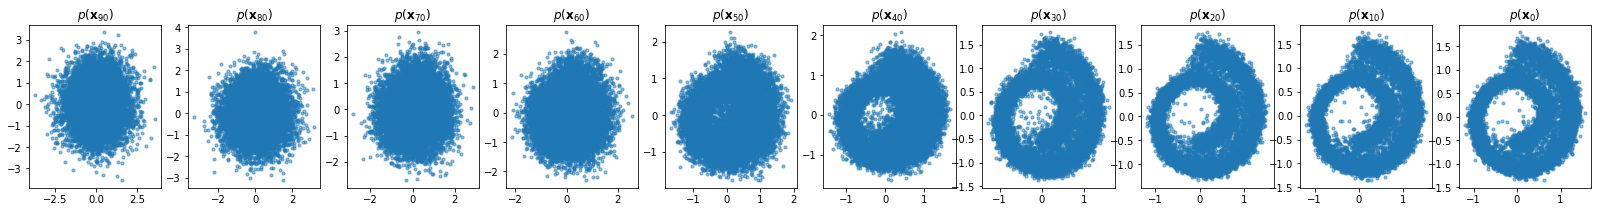

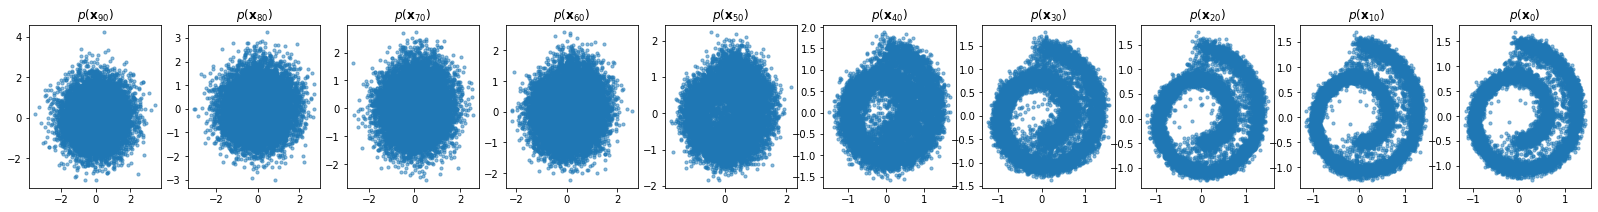

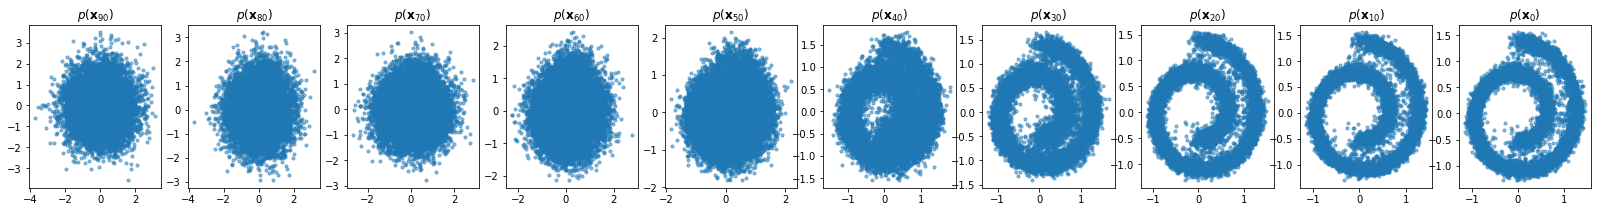

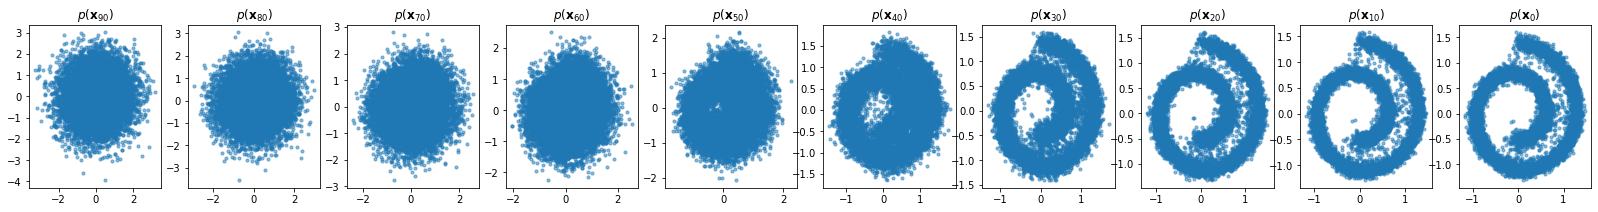

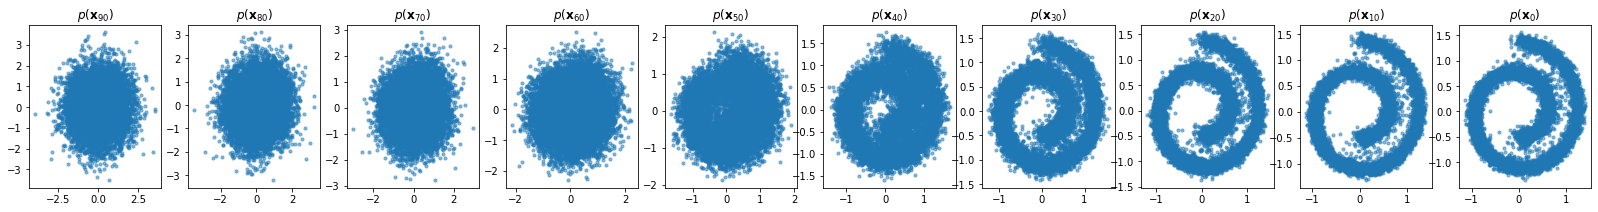

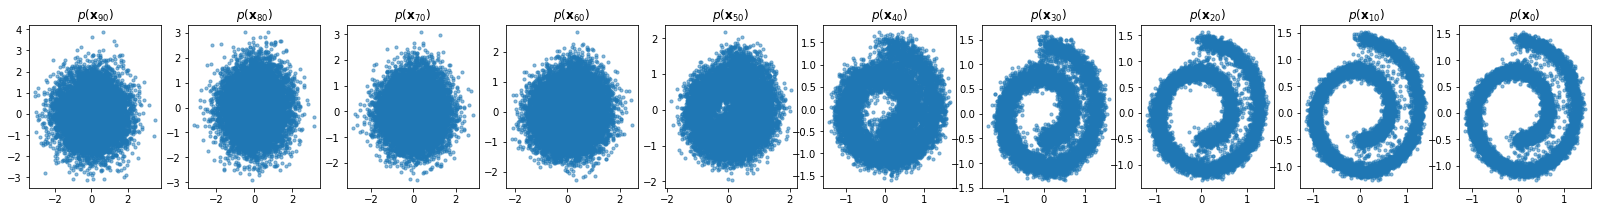

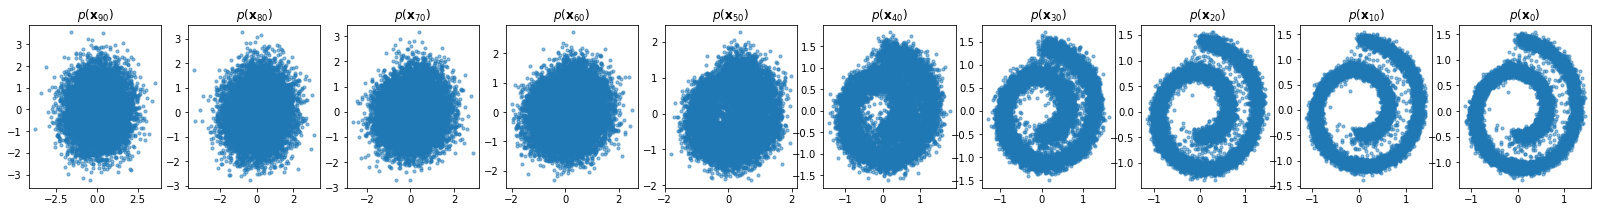

In [20]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10, alpha=0.5,);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$p(\mathbf{x}_{'+str(100-i*10)+'})$')